### Sources
- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
- https://towardsdatascience.com/interpretable-machine-learning-models-aef0c7be3fd9
- https://github.com/henniedeharder/interpretability-heart/blob/master/Demo_Forest_SHAP_Heart.ipynb
- https://www.kaggle.com/code/haobillylee/league-of-legends
- https://www.kaggle.com/code/ashutoshsinha/cs-go-round-winner-classification
- https://www.kaggle.com/code/timurrashitov/cs-go-match-outcome-with-neural-network-90

In [86]:
import numpy as np
import shap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [84]:
"""
Dataset
"""
data = pd.read_csv('csgo_round_snapshots.csv')
display(data.head(10))
display(data.describe())
print(data.shape)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
5,114.97,1.0,0.0,de_dust2,False,500.0,500.0,500.0,0.0,1750.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
6,94.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
7,74.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
8,54.97,1.0,0.0,de_dust2,False,249.0,89.0,269.0,0.0,2300.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
9,174.97,2.0,0.0,de_dust2,False,500.0,500.0,196.0,0.0,19800.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


(122410, 97)


In [85]:
"""
Check Columns (Null and non-numeric values)
"""
#null columns 
print("Columns:\n", data.isnull().any())
print("\nNumber of NULL columns:", data.isnull().sum().sum(), "\n")

#non-numeric values
display(data.drop(data.select_dtypes(np.number), axis = 1))


Columns:
 time_left                    False
ct_score                     False
t_score                      False
map                          False
bomb_planted                 False
                             ...  
ct_grenade_molotovgrenade    False
t_grenade_molotovgrenade     False
ct_grenade_decoygrenade      False
t_grenade_decoygrenade       False
round_winner                 False
Length: 97, dtype: bool

Number of NULL columns: 0 



,map,bomb_planted,round_winner
0,de_dust2,False,CT
1,de_dust2,False,CT
2,de_dust2,False,CT
3,de_dust2,False,CT
4,de_dust2,False,CT
...,...,...,...
122405,de_train,True,T
122406,de_train,False,T
122407,de_train,False,T
122408,de_train,False,T


T     62406
CT    60004
Name: round_winner, dtype: int64

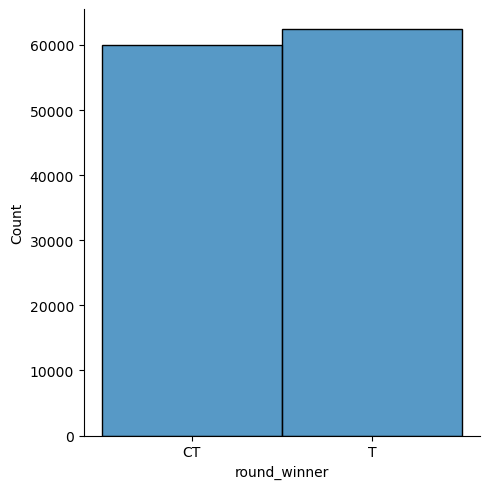

In [89]:
"""
Exploratory Data Analysis (EDA) 
"""
#number of round winners
sns.displot(data['round_winner'], kde=False)
data['round_winner'].value_counts()

map,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
round_winner,,,,,,,,
CT,103,10158,10810,9144,10214,7026,7310,5239
T,42,11986,13001,9432,8811,7055,6181,5898


<AxesSubplot:xlabel='round_winner', ylabel='count'>

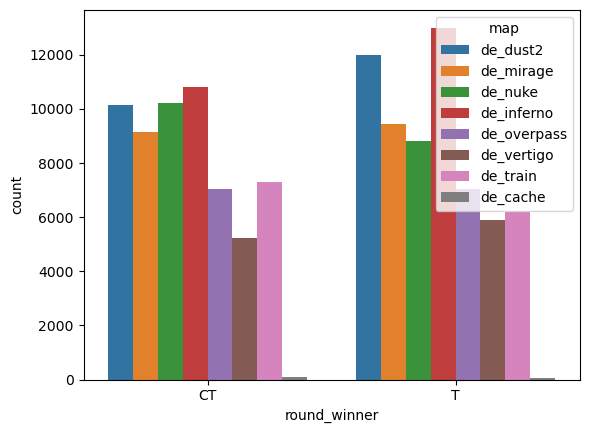

In [92]:
#comparing winners according to map 
display(pd.crosstab(data['round_winner'], data['map']))
sns.countplot(x='round_winner', hue='map', data=data)


In [95]:
"""
Convert non-numeric columns to numeric
"""
encoder = LabelEncoder() #create encoder

#bomb_planted to numeric
data['bomb_planted'] = data['bomb_planted'].astype(np.int16)


#map to numeric
data['map'] = encoder.fit_transform(data['map'])
map_mapping = {index : label for index, label in enumerate(encoder.classes_)}
print(map_mapping)


#round_winner to numeric
data['round_winner'] = encoder.fit_transform(data['round_winner'])
round_mapping = {index : label for index, label in enumerate(encoder.classes_)}
print(round_mapping)



#print data (everything should be numeric)
display(data.head(10))


{0: 'de_cache', 1: 'de_dust2', 2: 'de_inferno', 3: 'de_mirage', 4: 'de_nuke', 5: 'de_overpass', 6: 'de_train', 7: 'de_vertigo'}
{0: 'CT', 1: 'T'}


,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,1,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,156.03,0.0,0.0,1,0,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,96.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,76.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,174.97,1.0,0.0,1,0,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,114.97,1.0,0.0,1,0,500.0,500.0,500.0,0.0,1750.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
6,94.97,1.0,0.0,1,0,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,74.97,1.0,0.0,1,0,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,54.97,1.0,0.0,1,0,249.0,89.0,269.0,0.0,2300.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,174.97,2.0,0.0,1,0,500.0,500.0,196.0,0.0,19800.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [99]:
"""
Data Preprocessing
"""
#divide into y and x
y = data['round_winner']
x = data.drop(['round_winner'], axis=1)

display(y)
display(x)


"""
#normalization
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)
"""

# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


0         0
1         0
2         0
3         0
4         0
         ..
122405    1
122406    1
122407    1
122408    1
122409    1
Name: round_winner, Length: 122410, dtype: int32

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,175.00,0.0,0.0,1,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,156.03,0.0,0.0,1,0,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,76.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.97,1.0,0.0,1,0,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,6,1,200.0,242.0,195.0,359.0,100.0,...,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
122406,174.93,11.0,15.0,6,0,500.0,500.0,95.0,175.0,11500.0,...,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122407,114.93,11.0,15.0,6,0,500.0,500.0,495.0,475.0,1200.0,...,4.0,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0
122408,94.93,11.0,15.0,6,0,500.0,500.0,495.0,475.0,1200.0,...,1.0,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0


In [97]:
"""
Logistic Regression
"""
logistic_regression_model = LogisticRegression(random_state=10)
logistic_regression_model.fit(x_train, y_train)

y_train_pred_log = logistic_regression_model.predict(x_train)
y_test_pred_log = logistic_regression_model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred_log)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred_log)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred_log)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred_log)))


#decision tree






Accuracy on train:  0.7355403970263867
Recall on train:    0.7652820060887678
Accuracy on test:   0.7376848296707785
Recall on test:     0.7679115242827376


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
"""

"""